In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
import matplotlib.pyplot as plt
import os
import anndata
import harmonypy as hm
import seaborn as sns
import scrublet as scr
import bbknn as bk
%matplotlib inline
import glob
from statannotations.Annotator import Annotator
from itertools import combinations
from matplotlib import rcParams

/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sc.settings.set_figure_params(dpi=200,fontsize=10)

In [3]:
df = pd.read_csv("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Arterial_quantification/merged_ROIs.csv", index_col = 0)

In [4]:
df

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SULF1,SULF1_log2_mean,NEBL,SEMA3G,SEMA3G_log2_mean,RGCC,size,ROI,group,group2
ROI_A1-1_1,0,0.000000,0.0000,NaN,NaN,1.0,2.200000,1.137504,1.400000,10,A1-1,Small,Small
ROI_A1-1_12,0,0.000000,0.0625,1.000000,0.000000,1.2,2.384615,1.253757,1.000000,16,A1-1,Small,Medium
ROI_A1-1_5,0,0.000000,0.0000,NaN,NaN,1.0,2.000000,1.000000,NaN,7,A1-1,Small,Small
ROI_A1-2_0,0,0.481481,0.0000,3.034483,1.601451,NaN,1.000000,0.000000,NaN,81,A1-2,Large,Large
ROI_A1-2_4,0,0.166667,0.0000,1.333333,0.415038,NaN,1.000000,0.000000,1.000000,6,A1-2,Small,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ROI_D2-1_98,0,0.200000,0.0000,1.714286,0.777608,1.0,1.500000,0.584963,2.000000,15,D2-1,Small,Medium
ROI_D2-2_3,0,0.000000,0.0000,1.000000,0.000000,1.0,1.000000,0.000000,1.600000,14,D2-2,Small,Medium
ROI_D2-3_1,0,0.000000,0.0000,NaN,NaN,1.0,NaN,NaN,1.000000,7,D2-3,Small,Small
ROI_D2-3_24,0,0.000000,0.0000,1.000000,0.000000,1.0,1.000000,0.000000,NaN,7,D2-3,Small,Small


In [12]:
vessels = ['Large','Small']
pairs = list(combinations(vessels, r=2))
pairs

[('Large', 'Small')]

In [22]:
sns.set(rc={'figure.figsize':(0.8,2.5)})
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set(rc={'axes.edgecolor': 'black', 'axes.facecolor' : 'white', 'grid.color': 'whitesmoke', 'xtick.bottom': True, 'ytick.left': True})
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': 'black',
 'axes.grid': True,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': 'whitesmoke',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': <CapStyle.round: 'round'>,
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': True,
 'xtick.top': False,
 'ytick.left': True,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Large vs. Small: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.070e-08 U_stat=5.750e+02


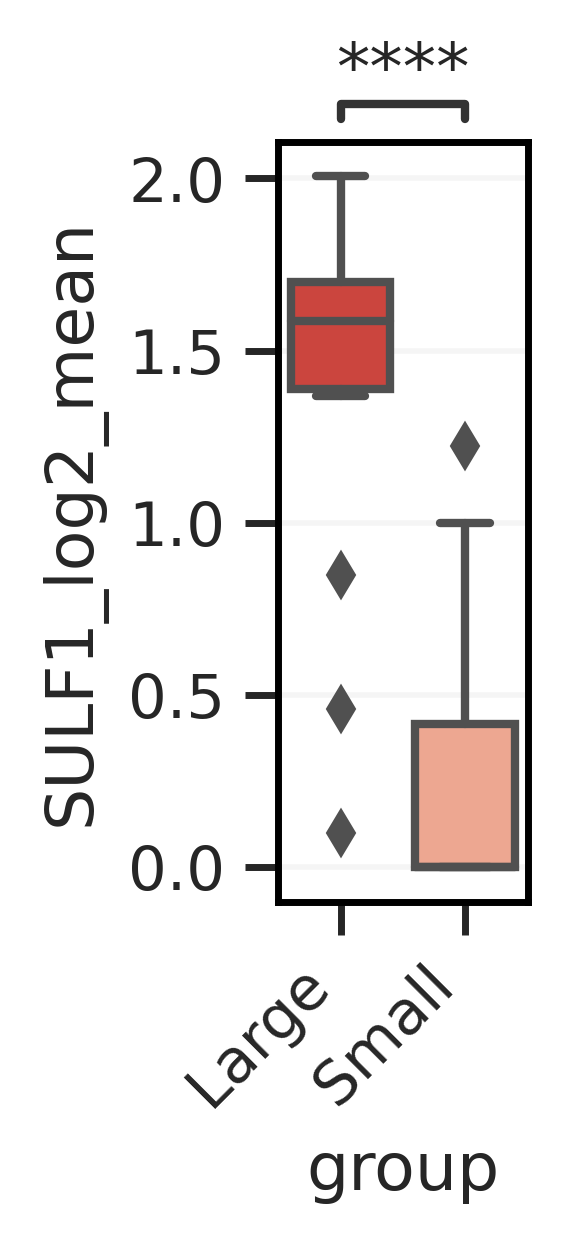

In [23]:
#SULF1 mean expression (bvins only expressed)
ax = sns.boxplot(data = df, x = "group", y = "SULF1_log2_mean", palette = 'Reds_r', order = ['Large','Small'])
annotator = Annotator(ax, pairs, data = df, x = "group", y = "SULF1", palette = 'Blues', order = ['Large','Small'])
annotator.configure(test="Mann-Whitney", text_format = 'star', loc = 'outside', comparisons_correction='benjamini-hochberg', text_offset=0)
plt.xticks(rotation=45, horizontalalignment = 'right')

annotator.apply_and_annotate()
#plt.savefig('SULF1_mean_expression', bbox_inches='tight')
plt.show()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Large vs. Small: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.070e-08 U_stat=5.750e+02


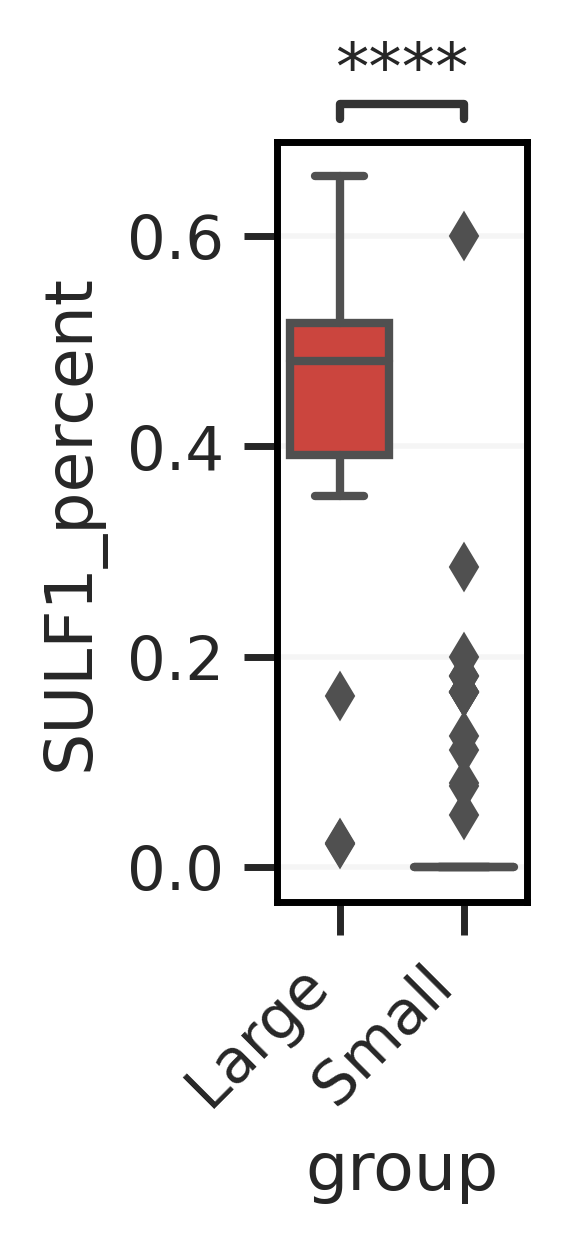

In [24]:
#SULF1 mean expression (bvins only expressed)
ax = sns.boxplot(data = df, x = "group", y = "SULF1_percent", palette = 'Reds_r', order = ['Large','Small'])
annotator = Annotator(ax, pairs, data = df, x = "group", y = "SULF1", palette = 'Blues', order = ['Large','Small'])
annotator.configure(test="Mann-Whitney", text_format = 'star', loc = 'outside', comparisons_correction='benjamini-hochberg', text_offset=0)
plt.xticks(rotation=45, horizontalalignment = 'right')

annotator.apply_and_annotate()
#plt.savefig('SULF1_percent.pdf', bbox_inches='tight')
plt.show()